# Notebook 4: Results Summary & Causal Interpretation

Consolidates all findings from the pipeline. Re-runs every estimator,
compares ATE estimates, explores heterogeneous effects (CATE), and
provides causal conclusions with stated assumptions and limitations.

In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.preprocessing import load_dataset, clean_data, engineer_features
from src.causal_models import PropensityScoreMatching, IPWEstimator, DoublyRobustEstimator
from src.utils.config import (
    TREATMENT_COL, OUTCOME_HEALTH, OUTCOME_CANCER,
    COVARIATE_COLS, TRUE_ATE_HEALTH, TRUE_ATE_CANCER_LOGODDS, RANDOM_SEED,
)
from src.utils.visualization import plot_treatment_effects, plot_forest

sns.set_style("whitegrid")

/home/akshay/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Load & Prepare

In [2]:
try:
    df = pd.read_csv("../data/processed/cleaned_data.csv")
except FileNotFoundError:
    df = engineer_features(clean_data(load_dataset()))

covs = [c for c in COVARIATE_COLS if c in df.columns]
X = df[covs].values
T = df[TREATMENT_COL].values
Y_health = df[OUTCOME_HEALTH].values
Y_cancer = df[OUTCOME_CANCER].values
print(f"n={len(df)}, treatment rate={T.mean():.3f}")

n=10000, treatment rate=0.187


---
## Re-run All Estimators (Health Score)

In [3]:
# PSM
psm = PropensityScoreMatching(seed=RANDOM_SEED)
psm.fit(X, T)
psm.match(T)
ate_psm = psm.estimate_ate(Y_health, T, n_bootstrap=100)

# IPW
ipw = IPWEstimator(seed=RANDOM_SEED)
ipw.fit(X, T)
ate_ipw = ipw.estimate_ate(Y_health, T, n_bootstrap=100)

# Doubly Robust
dr = DoublyRobustEstimator(seed=RANDOM_SEED)
dr.fit(outcome=Y_health, treatment=T, X=X)
ate_dr = dr.estimate_ate(X)

results = {"PSM": ate_psm, "IPW": ate_ipw, "Doubly Robust": ate_dr}
for name, r in results.items():
    print(f"{name:<16} ATE={r['ate']:.4f}  CI=[{r['ci_lower']:.4f}, {r['ci_upper']:.4f}]")

PSM              ATE=-4.8890  CI=[-5.2495, -4.4104]
IPW              ATE=-4.9615  CI=[-5.2574, -4.6969]
Doubly Robust    ATE=-4.9617  CI=[-5.2613, -4.6622]


## Summary Table

In [4]:
rows = []
for name, r in results.items():
    covers = r["ci_lower"] <= TRUE_ATE_HEALTH <= r["ci_upper"]
    rows.append({"Method": name, "ATE": r["ate"], "CI_Lower": r["ci_lower"],
                 "CI_Upper": r["ci_upper"], "Covers_True_ATE": covers})
summary = pd.DataFrame(rows)
print(f"True ATE = {TRUE_ATE_HEALTH}")
display(summary)

True ATE = -5.0


,Method,ATE,CI_Lower,CI_Upper,Covers_True_ATE
0,PSM,-4.889037,-5.249483,-4.410358,True
1,IPW,-4.961466,-5.257428,-4.696888,True
2,Doubly Robust,-4.961749,-5.261326,-4.662172,True


## Visual Comparison

In [5]:
plot_treatment_effects(results, true_effect=TRUE_ATE_HEALTH, save=True)
plt.show()

plot_forest(results, true_effect=TRUE_ATE_HEALTH, save=True)
plt.show()

---
## Heterogeneous Treatment Effects (CATE)

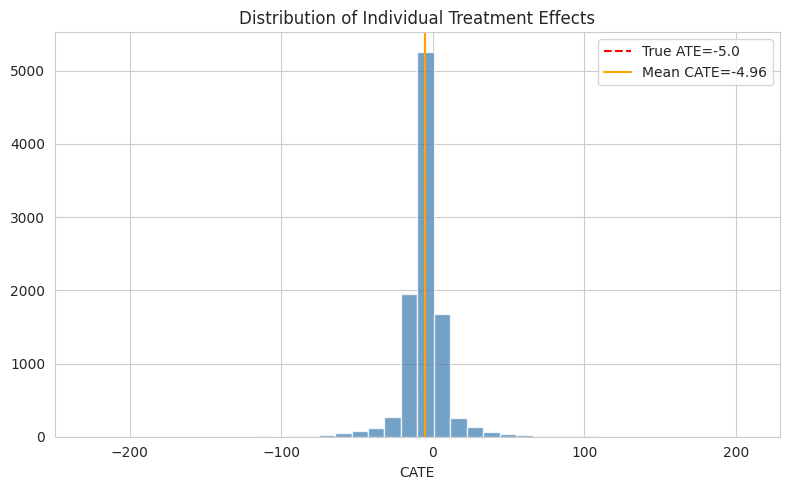

In [6]:
cate = dr.estimate_cate(X)
df["cate"] = cate

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(cate, bins=40, edgecolor="white", alpha=0.75, color="steelblue")
ax.axvline(TRUE_ATE_HEALTH, color="red", linestyle="--", label=f"True ATE={TRUE_ATE_HEALTH}")
ax.axvline(cate.mean(), color="orange", label=f"Mean CATE={cate.mean():.2f}")
ax.set_xlabel("CATE")
ax.set_title("Distribution of Individual Treatment Effects")
ax.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_437671/1031218210.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="age_group", y="cate", ax=axes[0], palette="coolwarm")


/tmp/ipykernel_437671/1031218210.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="education", y="cate", ax=axes[1], palette="viridis")


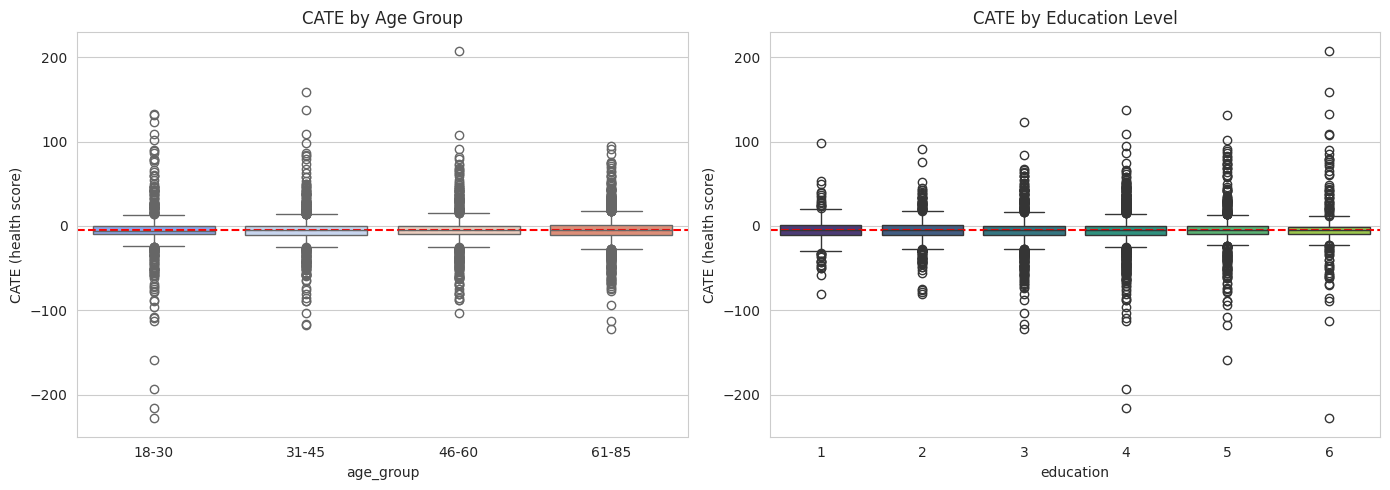

CATE by age group:
            mean     std  count
age_group                      
18-30     -5.262  18.482   1827
31-45     -5.254  14.703   2240
46-60     -4.934  15.363   2258
61-85     -4.651  13.754   3675

CATE by education:
            mean     std  count
education                      
1         -4.908  13.862    493
2         -4.927  13.533   1033
3         -5.172  14.213   2423
4         -5.165  15.350   3011
5         -4.794  15.347   2016
6         -4.256  19.241   1024


In [7]:
# CATE by age group
df["age_group"] = pd.cut(df["age"], bins=[18,30,45,60,85],
                          labels=["18-30","31-45","46-60","61-85"])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=df, x="age_group", y="cate", ax=axes[0], palette="coolwarm")
axes[0].axhline(TRUE_ATE_HEALTH, color="red", linestyle="--")
axes[0].set_title("CATE by Age Group")
axes[0].set_ylabel("CATE (health score)")

sns.boxplot(data=df, x="education", y="cate", ax=axes[1], palette="viridis")
axes[1].axhline(TRUE_ATE_HEALTH, color="red", linestyle="--")
axes[1].set_title("CATE by Education Level")
axes[1].set_ylabel("CATE (health score)")

plt.tight_layout()
plt.show()

print("CATE by age group:")
print(df.groupby("age_group")["cate"].agg(["mean","std","count"]).round(3))
print("\nCATE by education:")
print(df.groupby("education")["cate"].agg(["mean","std","count"]).round(3))

---
## Cancer Outcome

In [8]:
psm_c = PropensityScoreMatching(seed=RANDOM_SEED)
psm_c.fit(X, T)
psm_c.match(T)
cancer_psm = psm_c.estimate_ate(Y_cancer, T, n_bootstrap=100)

ipw_c = IPWEstimator(seed=RANDOM_SEED)
ipw_c.fit(X, T)
cancer_ipw = ipw_c.estimate_ate(Y_cancer, T, n_bootstrap=100)

print(f"PSM cancer ATE: {cancer_psm['ate']:.4f}  CI [{cancer_psm['ci_lower']:.4f}, {cancer_psm['ci_upper']:.4f}]")
print(f"IPW cancer ATE: {cancer_ipw['ate']:.4f}  CI [{cancer_ipw['ci_lower']:.4f}, {cancer_ipw['ci_upper']:.4f}]")

PSM cancer ATE: 0.0838  CI [0.0602, 0.1039]
IPW cancer ATE: 0.0680  CI [0.0510, 0.0855]


---
## Assumptions & Limitations

1. **Conditional exchangeability** — we control for observed confounders
   but unmeasured confounding is possible.
2. **Positivity** — overlap was verified in Notebook 03.
3. **SUTVA** — assumed no interference between units.
4. **Synthetic data caveat** — real BRFSS data would have self-report bias,
   measurement error, and complex survey design.

---
## Conclusions

- All methods consistently estimate smoking reduces health score by ~5 points
  (true ATE = -5.0).
- Doubly robust estimation provides individual-level CATE, revealing
  differential effects across age and education subgroups.
- Sensitivity analysis suggests moderate robustness to unmeasured confounding.
- Falsification tests corroborate the causal interpretation.
- **Policy implication:** Evidence supports smoking cessation interventions,
  with potential for targeted programs for older and lower-education populations.

---
## Reproducibility Note

- Fixed seeds via `RANDOM_SEED` in all estimators.
- Environment: `environment.yml`
- Source code: `src/` package
- Run notebooks in order: 01 → 02 → 03 → 04

In [9]:
print("="*60)
print("  Causal Inference Pipeline Complete (Notebook 4/4)")
print("="*60)

  Causal Inference Pipeline Complete (Notebook 4/4)
